# Install Detectron2 Dependencies

In [ ]:
!pip install pyyaml==5.1
!pip3 install onnx onnxruntime

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 16.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
torch:  2.5 ; cuda:  cu124
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-oyl0cd

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!curl -L "https://app.roboflow.com/ds/AchTu6cy7X?key=BMcrNgLuZj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2405      0 --:--:-- --:--:-- --:--:--  2402
100  101M  100  101M    0     0  12.3M      0  0:00:08  0:00:08 --:--:-- 16.4M
Archive:  roboflow.zip
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/0_jpg.rf.69240c77e27bd76319b79fdc8d45a81a.jpg  
 extracting: test/109_jpg.rf.077fce66469047a0143e6495469d2dd7.jpg  
 extracting: test/116_jpg.rf.4064d78bdf55a5cef13b24c849ce6aa1.jpg  
 extracting: test/138_jpg.rf.fc9e8371238188d8afd8dd61e85cac2b.jpg  
 extracting: test/13_jpg.rf.9b1445581843c4877b06e6cb12951e47.jpg  
 extracting: test/142_jpg.rf.ec7b6a3557dcbbed7de3f4c73639c36f.jpg  
 extracting: test/147_jpg.rf.e87fabc4549d1ef5fca6e645261a4ba8.jpg  
 extracting: test/180_jpg.rf.30cc4460ffcb806e94f05d9da4ddffa8.jpg  
 extracting: test/181_jpg.rf.b8f9ab52befef98a1ae591a9e63e4031.j

# Import and Register Custom Detectron2 Data

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("darts_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("darts_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [06/11 16:40:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/11 16:40:28 d2.data.datasets.coco]: Loaded 1850 images in COCO format from /content/train/_annotations.coco.json


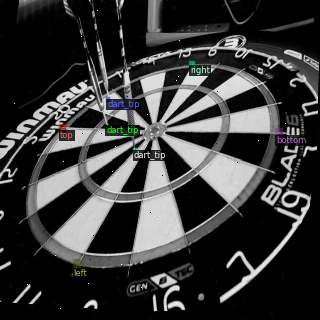

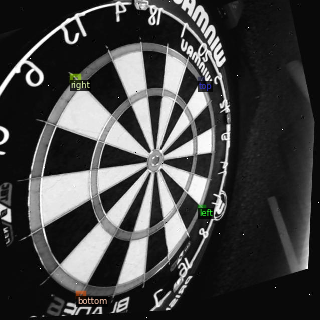

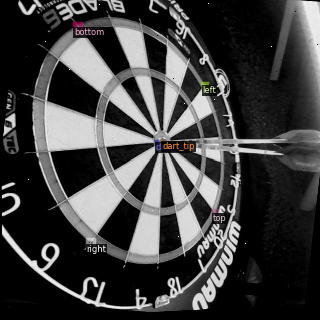

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("darts_dataset_train")
dataset_dicts = DatasetCatalog.get("darts_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/content/model_final.pth"

cfg.DATASETS.TRAIN = ("darts_dataset_train",)
cfg.DATASETS.TEST = ("darts_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.MAX_ITER = 15000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.TEST.EVAL_PERIOD = 1000

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000

cfg.SOLVER.STEPS = (12000, 16000)
cfg.SOLVER.GAMMA = 0.1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[06/11 16:40:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[06/11 16:40:47 d2.engine.train_loop]: Starting training from iteration 0
[06/11 16:41:02 d2.utils.events]:  eta: 2:49:24  iter: 19  total_loss: 0.398  loss_cls: 0.08297  loss_box_reg: 0.1569  loss_rpn_cls: 0.01216  loss_rpn_loc: 0.1434    time: 0.6638  last_time: 0.6751  data_time: 0.0625  last_data_time: 0.0512   lr: 9.9905e-05  max_mem: 8564M
[06/11 16:41:19 d2.utils.events]:  eta: 2:49:34  iter: 39  total_loss: 0.4189  loss_cls: 0.08972  loss_box_reg: 0.1689  loss_rpn_cls: 0.009874  loss_rpn_loc: 0.1393    time: 0.6693  last_time: 0.6902  data_time: 0.0604  last_data_time: 0.0610   lr: 0.0001998  max_mem: 8564M
[06/11 16:41:33 d2.utils.events]:  eta: 2:49:23  iter: 59  total_loss: 0.3971  loss_cls: 0.08797  loss_box_reg: 0.1621  loss_rpn_cls: 0.008691  loss_rpn_loc: 0.1348    time: 0.6688  last_time: 0.6879  data_time: 0.0598  last_data_time: 0.0622   lr: 0.0002997  max_mem: 8564M
[06/11 16:41:46 d2.utils.events]:  eta: 2:49:08  iter: 79  total_loss: 0.3807  loss_cls: 0.08237  loss

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import torch
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

# Quantize to INT8
model.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8
)

# Save quantized model
torch.save(quantized_model.state_dict(), "quantized_model.pth")

NameError: name 'build_model' is not defined

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("darts_dataset_test", )
predictor = DefaultPredictor(cfg)

[06/11 13:12:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


# Inference with Detectron2 Saved Weights



In [ ]:
import os
import glob
import cv2
import numpy as np
import onnxruntime as ort
from detectron2.data import transforms as T
from google.colab.patches import cv2_imshow

CLASS_NAMES = [
    "objects"
    "bottom",
    "dart_tip"
    "left",
    "right",
    "top"
]

onnx_session = ort.InferenceSession("model.onnx")
input_name = onnx_session.get_inputs()[0].name

CONF_THRESH = 0.5  # Confidence threshold

for image_path in glob.glob('/content/test/*.jpg'):
    im = cv2.imread(image_path)
    im_rgb = im[:, :, ::-1]

    # Resize like Detectron2 and keep transform
    transform = T.ResizeShortestEdge(
        [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
        cfg.INPUT.MAX_SIZE_TEST
    )
    aug = transform.get_transform(im_rgb)
    im_resized = aug.apply_image(im_rgb)

    # Convert to CHW and float32
    im_tensor = im_resized.astype("float32").transpose(2, 0, 1)

    # Run inference and get outputs
    boxes, class_ids, scores, _ = onnx_session.run(None, {input_name: im_tensor})

    print(class_ids)

    # Scale boxes back to original image size
    scale_x = im.shape[1] / im_resized.shape[1]
    scale_y = im.shape[0] / im_resized.shape[0]

    for i, (box, class_id, score) in enumerate(zip(boxes, class_ids, scores)):
        if score < CONF_THRESH:
            continue

        x1, y1, x2, y2 = box
        x1 = int(x1 * scale_x)
        y1 = int(y1 * scale_y)
        x2 = int(x2 * scale_x)
        y2 = int(y2 * scale_y)

        label = CLASS_NAMES[int(class_id)]
        text = f"{label}: {score:.2f}"

        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(im, text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    print(f"📸 Visualizing {os.path.basename(image_path)}")
    cv2_imshow(im)





NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from model.onnx failed:Load model model.onnx failed. File doesn't exist

In [ ]:
test_metadata = MetadataCatalog.get("darts_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("darts_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "darts_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [06/11 13:12:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/11 13:12:15 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/test/_annotations.coco.json
[06/11 13:12:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/11 13:12:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/11 13:12:15 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[06/11 13:12:15 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/11 13:12:15 d2.evaluation.evaluator]: Start inference on 50 batches
[06/11 13:12:15 d2.evaluation.evaluator]: Inference done 11/50. Dataloading: 0.0010 s/iter. Inference: 0.0267 s/iter. Eval: 0.0001 s/iter. Total: 0.0277 s/iter. ETA=0:00:01
[06/11 13:12:17 d2.evaluation.evalu